In [21]:
import numpy as np

import cvxpy as cp

from qutip import coherent, ket2dm, Qobj, expect, fidelity, fock, fock_dm, displace, coherent_dm
from qutip.visualization import plot_wigner_fock_distribution, plot_fock_distribution
from qutip.wigner import qfunc

from tqdm.auto import tqdm # progress bar

import matplotlib.pyplot as plt
from matplotlib import colors

import mpmath as mp
from scipy.special import factorial, eval_hermite, comb
from scipy.integrate import quad

from joblib import Parallel, delayed

### Define the harmonic oscillator wavefunction
To create homodyne POVM operators.

In [22]:
def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Set parameters
Set measurement parameters: number of angles and bins.
Also set Fock space cutoff.

In [23]:
eta = 0.5 # measurement efficiency

L = 5 # bin limit
Nbins = 20 # number of bins

dx =  2*L/Nbins # bin width

bins = [-L + i*dx for i in range(Nbins)] # list of bins

nangles = 20 # number of angles
thetas = np.linspace(0,np.pi, nangles) # list of all angles

#######
N = 25 # need some additional dimensions to properly construct the noise-compensated operators
N_cut = 8 # final Fock space dimension

### Define homodyne measurement operators
Without noise.

In [24]:
def get_Pis(theta, i):
    Pi = np.zeros((N,N),dtype=np.complex128)
    for m in range(N):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -L + i*dx, -L + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2

In [25]:
Pis = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in thetas for i in range(Nbins))

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 228 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    3.9s finished


### Construct the operator basis: Fock basis
The list `basis_dms` contains all $\Omega_k$

In [26]:
def get_basis_vectors(N):
    # construct vectors
    basis_vectors = []
    for i in range(N):
        vector = fock(N, i)
        basis_vectors.append(np.real(vector.full()))
    
    return basis_vectors
        
def get_basis_dms(N, basis_vectors):    
    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector1, vector2)
            basis_dms.append(dm)
            
    return basis_dms

In [27]:
basis_vectors  = get_basis_vectors(N) # needed for the adjusted operators
basis_dms = get_basis_dms(N, basis_vectors)

### Adjusted measurement operators 
Compensated for noise or inefficient detection.

In [28]:
def B(n,k, eta):
    return np.sqrt(comb(n+k,n) * eta**n * (1-eta)**k)

In [29]:
def get_adjusted_op(i,j):
        op = np.zeros((N,N), dtype=np.complex64)
        for n in range(N):
            for m in range(N):
                for k in range(N-max(m,n)):
                    op += B(m,k,eta)*B(n,k,eta)*Pis[i*Nbins + j][m,n] * np.outer(basis_vectors[n+k], basis_vectors[m+k])#
        return op

In [30]:
op_list = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(get_adjusted_op)(i,j) for i in range(nangles) for j in range(Nbins))

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 228 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    4.2s finished


### Load homodyne data into $\vec b$

In [31]:
b_all = []
for idx, theta in enumerate(thetas):
    file = 'simulated_homodyne_currents_eta0.5/homodyne_current' + str(idx+1) +'_eta'+str(eta)+ '0.dat'
    current = np.loadtxt(file)
    counts, bins_file = np.histogram(current,Nbins,density=1, range=[-L,L]);

    b_all.append(counts)
    
b = np.concatenate([array for array in b_all])

### Construct the matrix A in $A\vec\rho=\vec b$

In [32]:
op_list_cut = [op[:N_cut,:N_cut] for op in op_list]

basis_vectors_cut = get_basis_vectors(N_cut)
basis_dms_cut = get_basis_dms(N_cut, basis_vectors_cut)

In [33]:
A = np.zeros((len(Pis), N_cut*N_cut), dtype=np.complex64)

for index, a in tqdm(np.ndenumerate(A)):
    A[index] = np.trace(op_list[index[0]][:N_cut,:N_cut] @ basis_dms_cut[index[1]]);

0it [00:00, ?it/s]

## Convex optimization

Define the unknown state as a $N\times N$ Hermitian matrix

In [34]:
X = cp.Variable((N_cut,N_cut), hermitian=True)

Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

In [35]:
cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint, respectively.
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False)

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

WARN: A->p (column pointers) not strictly increasing, column 437 empty
WARN: A->p (column pointers) not strictly increasing, column 446 empty
WARN: A->p (column pointers) not strictly increasing, column 455 empty
WARN: A->p (column pointers) not strictly increasing, column 464 empty
WARN: A->p (column pointers) not strictly increasing, column 473 empty
WARN: A->p (column pointers) not strictly increasing, column 482 empty
WARN: A->p (column pointers) not strictly increasing, column 491 empty
WARN: A->p (column pointers) not strictly increasing, column 500 empty


/home/ingrid/.pyenv/versions/3.9.5/envs/qctrl39env/lib/python3.9/site-packages/cvxpy/interface/numpy_interface/ndarray_interface.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  return result.astype(numpy.float64)


### Visualize results
Inefficiency was $\eta=0.5$.

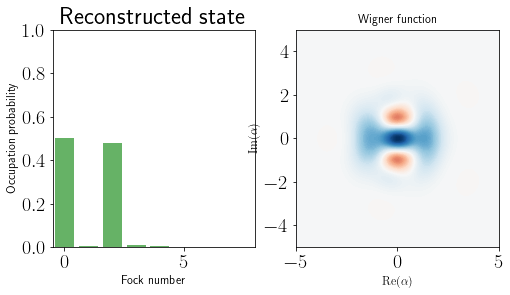

In [36]:
#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=alpha_max)
ax[0].set_title("Reconstructed state");

### Comparison to ideal state

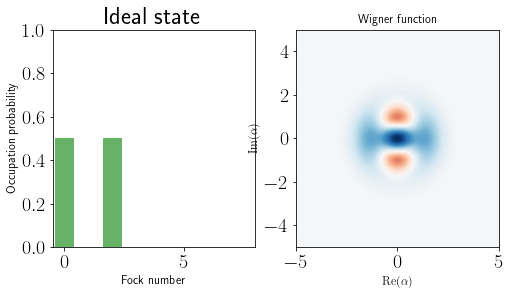

In [41]:
rho = (fock(N_cut,0) + fock(N_cut,2)).unit()

fig, ax = plot_wigner_fock_distribution(rho, alpha_max=alpha_max)
ax[0].set_title("Ideal state");

In [38]:
print("Fidelity {:.4}".format(fidelity(reconstructed_rho, rho)**2));

Fidelity 0.98
